In [1]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = (r"C:\Users\Arnash Das\OneDrive\Desktop\Lung cancer\Data\train")
val_path = (r"C:\Users\Arnash Das\OneDrive\Desktop\Lung cancer\Data\valid")
test_path = (r"C:\Users\Arnash Das\OneDrive\Desktop\Lung cancer\Data\test")

In [4]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


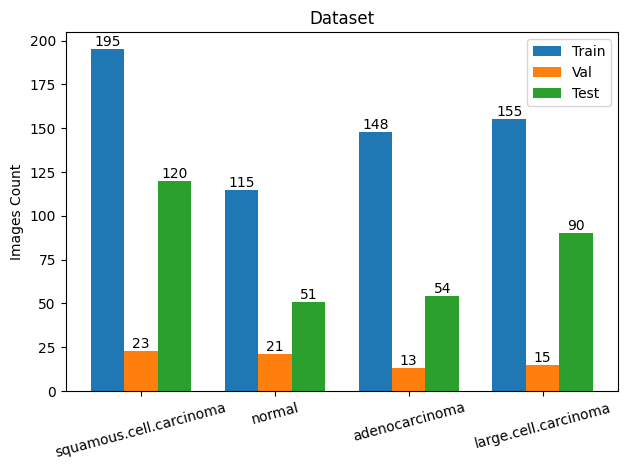

In [5]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [7]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [8]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [9]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [10]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [11]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

In [13]:
from keras import layers
for layer in base_model.layers:
    layer.trainable = False

In [14]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
x = layers.Flatten()(base_model.output)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(4, activation='sigmoid')(x)

model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])
model_incep.save("./best_model.keras")

In [15]:
# Adding Model check point Callback
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(
    filepath="./best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [16]:
# Fitting the Model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 50, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.3355 - loss: 9.2810
Epoch 1: val_accuracy improved from -inf to 0.48571, saving model to ./best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 113s 861ms/step - accuracy: 0.3363 - loss: 9.2432 - val_accuracy: 0.4857 - val_loss: 1.0699
Epoch 2/50
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:22 680ms/step - accuracy: 0.6000 - loss: 1.5650
Epoch 2: val_accuracy did not improve from 0.48571
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6000 - loss: 1.5650 - val_accuracy: 0.4000 - val_loss: 1.6146
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.5494 - loss: 1.2862
Epoch 3: val_accuracy improved from 0.48571 to 0.61429, saving model to ./best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 95s 777ms/step - accuracy: 0.5494 - loss: 1.2862 - val_accuracy: 0.6143 - val_loss: 0.7554
Epoch 4/50
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:21 674ms/step - accuracy: 0.8000 - loss: 0.4961
Epoch 4: val_accuracy did not improve from 0.61429
122/

In [17]:
# Loading the Best Fit Model 
from pyexpat import model
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
model= load_model("./best_model.keras")

In [18]:
# Checking the Accuracy of the Model 
accuracy_incep = model.evaluate(test_data)[1] 
print(f"The accuracy of the model is = {accuracy_incep*100} %")

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 489ms/step - accuracy: 0.8160 - loss: 0.5461
The accuracy of the model is = 81.90476298332214 %


In [19]:
incep.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

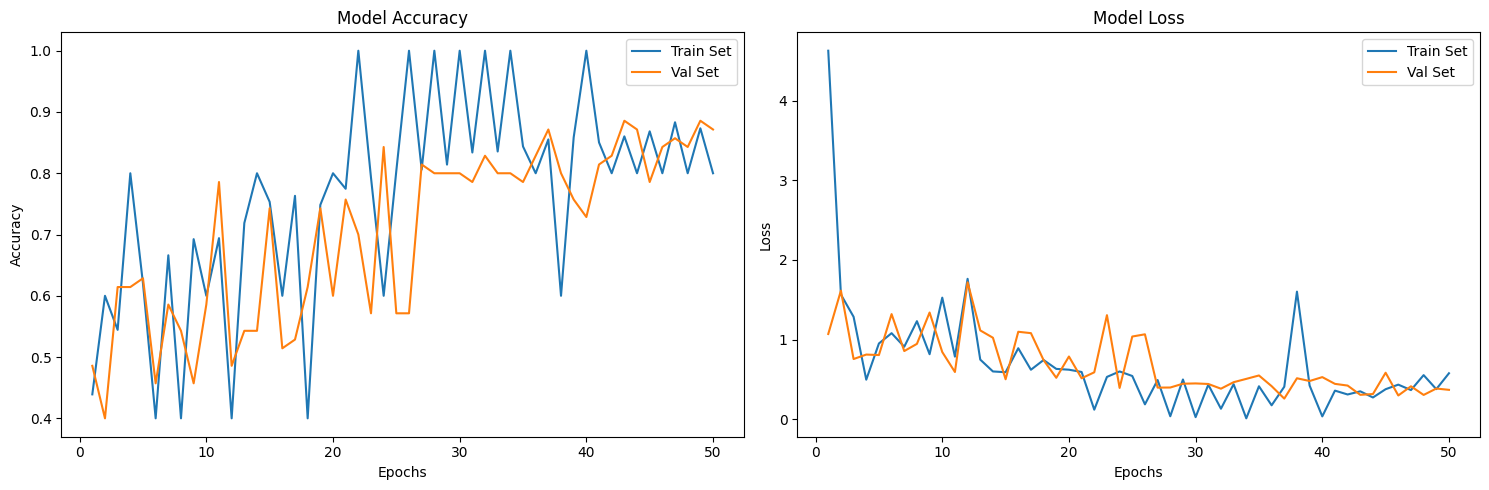

In [20]:
# Plot model performance
acc = incep.history['accuracy']
val_acc = incep.history['val_accuracy']
loss = incep.history['loss']
val_loss = incep.history['val_loss']
epochs_range = range(1, len(incep.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()